In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import caffe
import time
import glob
import scipy
import csv
import itertools

In [2]:
# Set the csv limitation 
maxInt = sys.maxsize
decrement = True

while decrement:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    decrement = False
    try:
        csv.field_size_limit(maxInt)
    except OverflowError:
        maxInt = int(maxInt/10)
        decrement = True

In [3]:
def read_files(path,fileType):
    dimg_files = []
    for root, directories, filenames in os.walk(path):
        for filename in filenames:
            if fileType in filename:
                dimg_files.append(os.path.join(root,filename))
    return dimg_files

In [5]:
def getfrombigtxt(fname, delimiter=' '):
    tmp = []
    with open(fname, 'r') as f: # note text mode, not binary
        for row in csv.reader(f):
            for elements in row[0].split(delimiter):
#                 tmp.append(map(float, elements))
                tmp.append((elements))
    del tmp[-1]
    return np.asarray(tmp,dtype=np.float32)

In [7]:
def get_image_path(basename,path,ext):
    return(path + os.path.basename(basename).split('.')[0] + ext)

In [8]:
def loss_rate(arr1, arr2):
#     print arr1, arr2
    return np.sum(np.absolute(np.subtract(arr1,arr2)))/len(arr1)

In [9]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(np.sum(targets*np.log(predictions+1e-9)))/N
    return ce

In [10]:
# function is to show layer data by gray image
def show_data(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.imshow(data,cmap='gray')
    plt.axis('on')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [51]:
def caffe_inference(image_path):
    
    # Configure
    pycaffe_dir = '/home/caslab/workspace/caffe/caffe/python/'
    model_dir = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/model/yolo'
    input_file = image_path
    model_def = os.path.join(model_dir,"prototxt/yolo_tiny_deploy_10.prototxt")
    pretrained_model = os.path.join(model_dir,"weight/yolo_tiny.caffemodel")
    gpu = False
    center_only = True
    images_dim = '448,448'
    mean_file = '/home/caslab/workspace/caffe/caffe/examples/cifar10/mean.npy'
    # input_scale = 
    raw_scale = 255.0
    channel_swap = '2,1,0'
    ext = 'jpg'
    image_dims = [int(s) for s in images_dim.split(',')]
    mean, channel_swap_arr = None, None
    
    
    
    # Setup parameter
    if mean_file:
        mean = np.load(mean_file)
    if channel_swap:
        channel_swap_arr = [int(s) for s in channel_swap.split(',')]
    if gpu:
        caffe.set_mode_gpu()
    else:
        caffe.set_mode_cpu()

    
    # Create classifier class
    classifier = caffe.Classifier(model_def, pretrained_model,
            image_dims=image_dims, mean=None,
    #         image_dims=image_dims, mean=mean,
            raw_scale=raw_scale,
            channel_swap=channel_swap_arr)


    
    # Load image file.
    inputs =[caffe.io.load_image(input_file)]
    load_img_time_end = time.time()

    # Classify
    predictions = classifier.predict(inputs, not center_only)
    
    return predictions[0]

In [52]:
image_path = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/dog448.jpg'
dimg_path = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/runtime/yolo_dimg_each_448/yolo_tiny_deploy_10.prototxt.dimg'

32


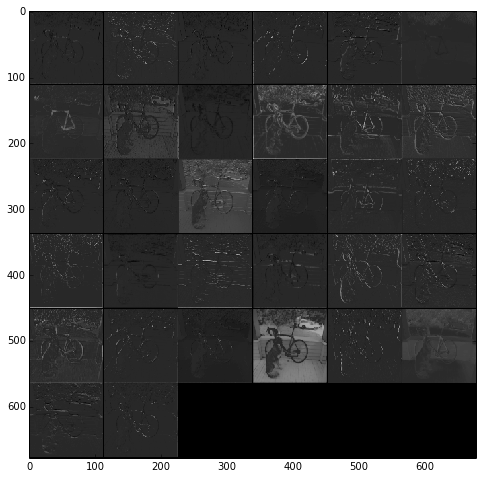

In [53]:
caffe_result = (caffe_inference(image_path))
print len(caffe_result)
show_data(caffe_result)

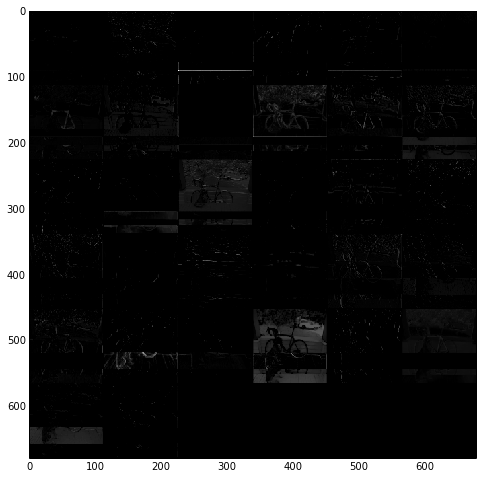

In [54]:
# nvdla_result = (read_dimg(dimg_path))

nvdla_result = getfrombigtxt(dimg_path)

nvdla_feature_map = nvdla_result.reshape(len(caffe_result),len(caffe_result[0]),-1)

show_data(nvdla_feature_map)

In [50]:
loss_rate(nvdla_result,caffe_result.reshape(1,-1))

0.24357141767229354